# Dog Skin Diseases Classification

The notebook incorporates the model utilized for classifying skin diseases of dogs (3 diseases and 1 healthy class). A customley made datasetspecially for Sri Lanka is used for training, validating and testing the model. The development of the classification model followed a transfer learning approach, using ResNet152V2 Keras application. To assess the performance of the model, several evaluation metrics were employed, including accuracy, F1-score, precision, recall, and evaluation matrix. The output from each metric indicates that the model achieved a high level of accuracy in classifying the eye images.


### Importing required libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2

In [2]:
# Set dataset path
TRAIN_PATH = r'E:\Year04\IRP\dataset\organized_data_augment\train'
VAL_PATH = r'E:\Year04\IRP\dataset\organized_data_augment\val'
TEST_PATH = r'E:\Year04\IRP\dataset\organized_data_augment\test'

In [3]:
# Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

### Initializing train, validation & test data

In [4]:
# Data Generators
train_gen = datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_gen = datagen.flow_from_directory(
    VAL_PATH,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 8795 images belonging to 4 classes.
Found 2513 images belonging to 4 classes.
Found 1257 images belonging to 4 classes.


### Plot Images with labels

In [5]:
# Get class labels
class_labels = list(train_gen.class_indices.keys())
print("Class Labels:", class_labels)

Class Labels: ['canine_scabies', 'fungal_infection', 'healthy', 'hypersensitivity_allergies']


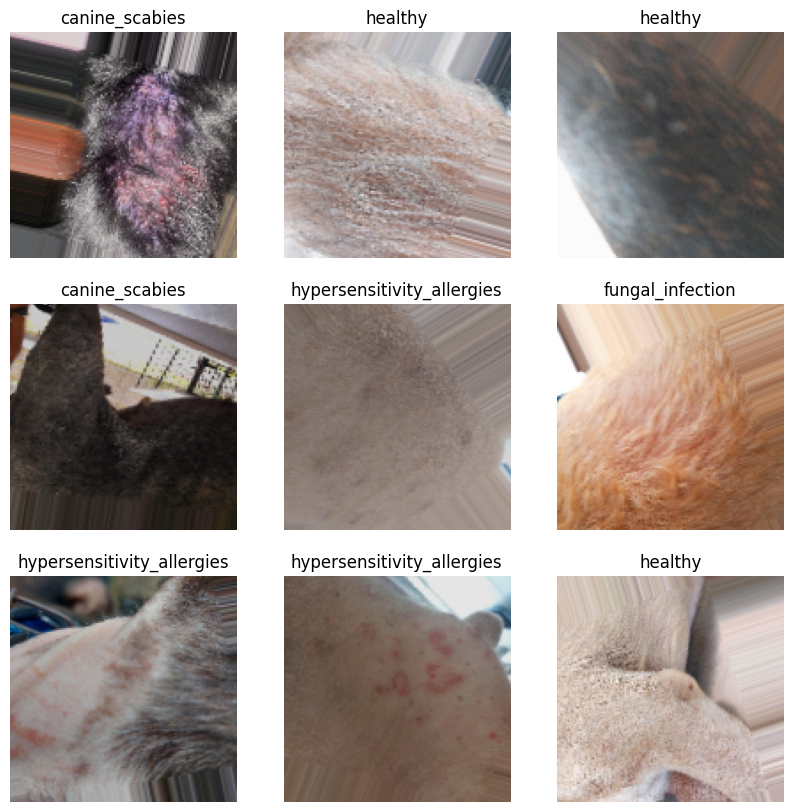

In [6]:
# Visualize Some Images
def visualize_images(generator):
    images, labels = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(class_labels[np.argmax(labels[i])])
        plt.axis("off")
    plt.show()

visualize_images(train_gen)

ResNet152v2


In [7]:
  # Model Initialization
ResNet_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


# The last 15 layers fine tune
for layer in ResNet_model.layers[:-15]:
    layer.trainable = False

In [8]:
model = Sequential([
    ResNet_model,
    GlobalAveragePooling2D(),
    Dense(units=512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(train_gen.num_classes, activation='softmax')
    #Dense(len(train_gen.class_names), activation='softmax')
])


model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 4, 4, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                        

In [9]:
# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [10]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, min_lr=1e-6)
checkpoint = ModelCheckpoint('resnet152v2_best_model.h5', monitor='val_accuracy', save_best_only=True)


In [11]:
# Training
history = model.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen,
    callbacks=[early_stop, reduce_lr, checkpoint]
)


Epoch 1/30
275/275 [==============================] - ETA: 0s - loss: 2.0162 - accuracy: 0.5585 - precision: 0.7139 - recall: 0.3280

c:\anaconda\envs\gpu_py\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


275/275 [==============================] - 1418s 5s/step - loss: 2.0162 - accuracy: 0.5585 - precision: 0.7139 - recall: 0.3280 - val_loss: 1.6632 - val_accuracy: 0.6562 - val_precision: 0.7266 - val_recall: 0.5595 - lr: 0.0010
Epoch 2/30
275/275 [==============================] - 1407s 5s/step - loss: 1.3319 - accuracy: 0.6797 - precision: 0.7731 - recall: 0.5306 - val_loss: 1.1286 - val_accuracy: 0.7055 - val_precision: 0.7728 - val_recall: 0.6025 - lr: 0.0010
Epoch 3/30
275/275 [==============================] - 4578s 17s/step - loss: 1.0432 - accuracy: 0.7160 - precision: 0.7898 - recall: 0.6045 - val_loss: 0.9376 - val_accuracy: 0.7314 - val_precision: 0.7860 - val_recall: 0.6634 - lr: 0.0010
Epoch 4/30
275/275 [==============================] - 1387s 5s/step - loss: 0.8897 - accuracy: 0.7413 - precision: 0.8034 - recall: 0.6462 - val_loss: 0.9408 - val_accuracy: 0.7008 - val_precision: 0.7761 - val_recall: 0.5806 - lr: 0.0010
Epoch 5/30
275/275 [==============================] - 

In [15]:
# Save Final Model
model.save('resnet152v2_dog_skin_disease.h5')

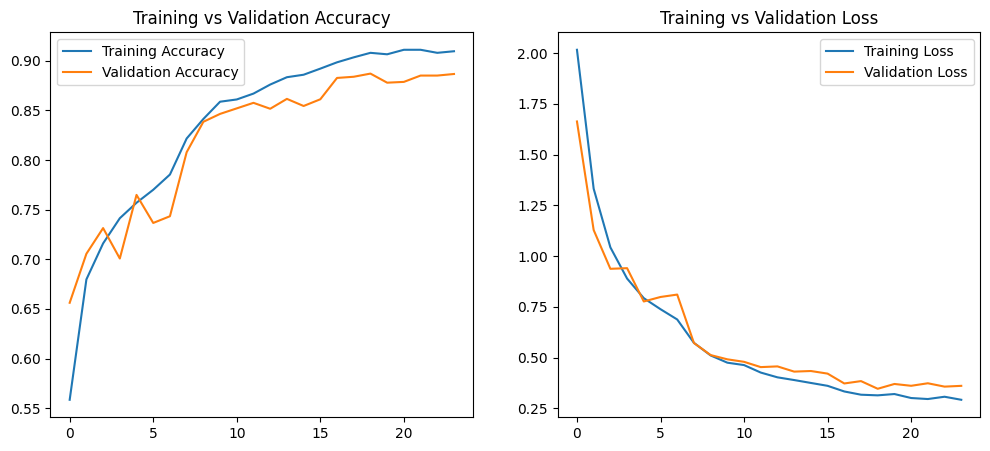

In [12]:
# Evaluation
# Plot Training vs Validation Accuracy and Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'] , label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()

In [13]:
from keras.models import load_model

# Load the saved model
saved_model = load_model('resnet152v2_best_model.h5')

# Evaluate on training data
train_results = saved_model.evaluate(train_gen, verbose=0)
print(f"Training - Loss: {train_results[0]:.4f}, Accuracy: {train_results[1]*100:.2f}%, Precision: {train_results[2]*100:.2f}%, Recall: {train_results[3]*100:.2f}%")

# Evaluate on validation data
val_results = saved_model.evaluate(val_gen, verbose=0)
print(f"Validation - Loss: {val_results[0]:.4f}, Accuracy: {val_results[1]*100:.2f}%, Precision: {val_results[2]*100:.2f}%, Recall: {val_results[3]*100:.2f}%")

# Evaluate on test data
test_results = saved_model.evaluate(test_gen, verbose=0)
print(f"Test - Loss: {test_results[0]:.4f}, Accuracy: {test_results[1]*100:.2f}%, Precision: {test_results[2]*100:.2f}%, Recall: {test_results[3]*100:.2f}%")


Training - Loss: 0.2612, Accuracy: 92.05%, Precision: 92.72%, Recall: 91.37%
Validation - Loss: 0.3952, Accuracy: 87.47%, Precision: 88.15%, Recall: 86.75%
Test - Loss: 0.2957, Accuracy: 91.81%, Precision: 92.72%, Recall: 91.17%


In [15]:
prediction_effnet = saved_model.predict(test_gen) 
prediction_effnet=np.argmax(prediction_effnet,axis=1)

In [16]:
true_labels = []

# Iterate only through the number of batches
for i in range(len(test_gen)):
    image_batch, label_batch = test_gen[i]
    true_labels.append(label_batch)

# Concatenate and convert to numpy
correct_labels = tf.concat(true_labels, axis=0).numpy()


In [17]:
print(type(prediction_effnet))
print(type(correct_labels))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


Classification Report:
                            precision    recall  f1-score   support

            canine_scabies       0.95      0.91      0.93       333
          fungal_infection       0.93      0.85      0.89       344
                   healthy       0.86      0.98      0.92       333
hypersensitivity_allergies       0.94      0.94      0.94       247

                  accuracy                           0.92      1257
                 macro avg       0.92      0.92      0.92      1257
              weighted avg       0.92      0.92      0.92      1257



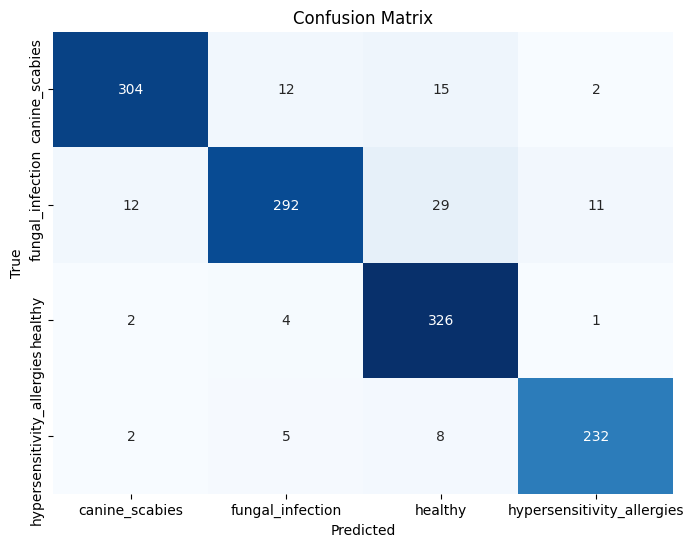

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Convert one-hot encoded labels to class indices if needed
if correct_labels.ndim > 1:
    correct_labels = np.argmax(correct_labels, axis=1)

# Convert predictions to class indices if they are probabilities
if prediction_effnet.ndim > 1:
    prediction_effnet = np.argmax(prediction_effnet, axis=1)

# Ensure both arrays are integers
correct_labels = correct_labels.astype(int)
prediction_effnet = prediction_effnet.astype(int)

# List of class names (Modify with your actual class names)
class_names = ['canine_scabies', 'fungal_infection', 'healthy', 'hypersensitivity_allergies']

# Generate Classification Report
print("Classification Report:")
print(classification_report(correct_labels, prediction_effnet, target_names=class_names))

# Compute Confusion Matrix
conf_matrix = confusion_matrix(correct_labels, prediction_effnet)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


### Using the model for classification

In [21]:
from keras.models import load_model

load_imagePath = r'E:\Year04\IRP\dataset\dogs\healthy\20240906_104434.jpg'
saved_model = load_model(r'resnet152v2_best_model.h5')

In [22]:
image_size = (128 ,128)

<class 'numpy.ndarray'>
[[0. 0. 1. 0.]]
Classification:  healthy
Value 1.0


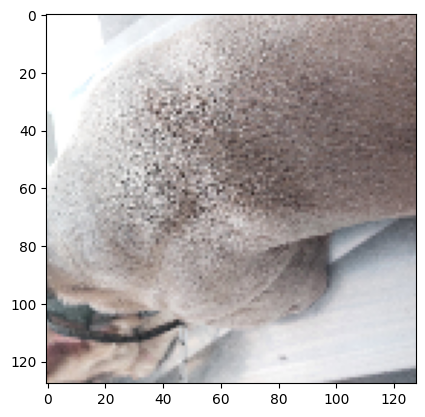

In [23]:
from keras.preprocessing import image

test_img = image.load_img(load_imagePath, target_size = image_size) 
test_image = image.img_to_array(test_img)
test_image = np.expand_dims(test_image, axis = 0)
print(type(test_image))    
result = saved_model.predict(test_image)
print(result)
plt.imshow(test_img) 
print("Classification: ",class_names[int(np.argmax(result,axis=1))])
print("Value", np.amax(result))